In [1]:
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('INFO')
import sys

import core.data as data
from core.analysis import *
from core.visualization import *

logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

In [2]:
import braindecode
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# load nn model from braindecode
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from braindecode.models.deep4 import Deep4Net
from torch import nn
from braindecode.torch_ext.util import set_random_seeds

%load_ext autoreload
%autoreload 2

In [3]:
# load data 
x_loaded, y_loaded = data.load_x('data/x_train.h5'), data.load_y('data/y_train.csv')

Started loading file data/x_train.h5
Finished loading the file.
Started loading file data/y_train.csv
Finished loading the file.


In [4]:
# convert y to categorical with np.eye(d)[y_loaded]
# and flatten the 40 independent samples
x_swaped = swap_correlated_channels(x_loaded)

x, y = data.flatten_x(x_swaped), data.flatten_y(y_loaded, repeat=40)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.66)
x_train, x_test = x_train.squeeze(), x_test.squeeze()

# Only one value : 0 or 1  
y_train, y_test = np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)

# get class weights
weights = data.class_weights(y_train)

print('shape : ', x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print('weights :', weights)

shape :  (24974, 7, 500) (12866, 7, 500) (24974,) (12866,)
weights : [0.64312938 2.24667146]


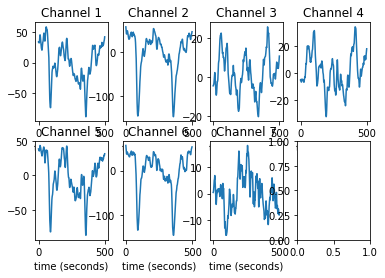

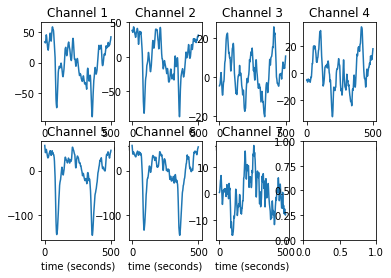

In [5]:
x_swaped = swap_correlated_channels(x_loaded)

i, j = 4, 1

plot_eeg_sample(x_loaded[i, j])
plot_eeg_sample(x_swaped[i, j])

In [12]:
# define the model

cuda = False
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = x_train.shape[1]
input_time_length=x_train.shape[2]
final_conv_length='auto'
# final_conv_length = auto ensures we only get a single output in the time dimension
# model = Deep4Net(in_chans=in_chans, n_classes=n_classes, input_time_length=input_time_length, final_conv_length=final_conv_length)
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=input_time_length,
                        final_conv_length=final_conv_length)

from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
#optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
optimizer = AdamW(model.parameters(), lr=0.0625 * 0.01, weight_decay=0)
criterion = lambda prediction, targets : F.nll_loss(prediction, targets, weight=torch.from_numpy(weights).float())
# below for no weights
# criterion = lambda prediction, targets : F.nll_loss(prediction, targets)
model.compile(loss=criterion, optimizer=optimizer, iterator_seed=1,)

In [13]:
model.fit(x_train, y_train, epochs=20, batch_size=64, scheduler='cosine'
         ,validation_data=(x_test, y_test)
         ,input_time_length = 450) # supercropsize for cropped training
# Rk : here, 1 timestep = 1 / 250 seconds

20-Mar-20 17:22:27 | INFO | Run until first stop...
20-Mar-20 17:23:03 | INFO | Epoch 0
20-Mar-20 17:23:03 | INFO | train_loss                1.20124
20-Mar-20 17:23:03 | INFO | valid_loss                1.21098
20-Mar-20 17:23:03 | INFO | train_misclass            0.50849
20-Mar-20 17:23:03 | INFO | valid_misclass            0.50987
20-Mar-20 17:23:03 | INFO | runtime                   0.00000
20-Mar-20 17:23:03 | INFO | 
20-Mar-20 17:24:48 | INFO | Time only for training updates: 104.87s
20-Mar-20 17:25:17 | INFO | Epoch 1
20-Mar-20 17:25:17 | INFO | train_loss                2.40939
20-Mar-20 17:25:17 | INFO | valid_loss                2.45084
20-Mar-20 17:25:17 | INFO | train_misclass            0.77116
20-Mar-20 17:25:17 | INFO | valid_misclass            0.77553
20-Mar-20 17:25:17 | INFO | runtime                   140.40115
20-Mar-20 17:25:17 | INFO | 
20-Mar-20 17:26:52 | INFO | Time only for training updates: 94.84s
20-Mar-20 17:27:21 | INFO | Epoch 2
20-Mar-20 17:27:21 | INFO

20-Mar-20 18:02:32 | INFO | train_misclass            0.41723
20-Mar-20 18:02:32 | INFO | valid_misclass            0.41248
20-Mar-20 18:02:32 | INFO | runtime                   121.44161
20-Mar-20 18:02:32 | INFO | 
20-Mar-20 18:04:04 | INFO | Time only for training updates: 92.28s
20-Mar-20 18:04:33 | INFO | Epoch 19
20-Mar-20 18:04:33 | INFO | train_loss                0.69167
20-Mar-20 18:04:33 | INFO | valid_loss                0.69128
20-Mar-20 18:04:33 | INFO | train_misclass            0.24758
20-Mar-20 18:04:33 | INFO | valid_misclass            0.24250
20-Mar-20 18:04:33 | INFO | runtime                   121.07309
20-Mar-20 18:04:33 | INFO | 
20-Mar-20 18:06:08 | INFO | Time only for training updates: 95.58s
20-Mar-20 18:06:37 | INFO | Epoch 20
20-Mar-20 18:06:37 | INFO | train_loss                0.68934
20-Mar-20 18:06:37 | INFO | valid_loss                0.68941
20-Mar-20 18:06:37 | INFO | train_misclass            0.27973
20-Mar-20 18:06:37 | INFO | valid_misclass      

In [14]:
x_challenge = data.load_x('data/x_test.h5')
x_challenge = data.flatten_x(x_challenge).squeeze()

Started loading file data/x_test.h5
Finished loading the file.


In [15]:
# average the predictions of all the indepedent trials to return one classification for each subject
def average_predictions(predictions, nb_trials = 40):
    # number of samples
    n = int(len(predictions) / nb_trials)
    avg_preds = np.zeros(n)
    for i in range(n):
        sample_preds = predictions[i*nb_trials:(i+1)*nb_trials]
        avg_preds[i] = int(np.mean(sample_preds) > 0.5)
    return avg_preds

In [16]:
y_challenge = model.predict_classes(x_challenge)
y_challenge2 = data.average_predictions(y_challenge)

In [17]:
# first, display the predictions
print(y_challenge2)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [18]:
from core.data import save_csv 
save_csv(y_challenge2, 'data/result.csv')

### Vizualise the neural network (recepive field)